# Life-Expectancy Exploratory Data Analysis (EDA)

In this module we will dive into an exploratory data analysis (EDA) on the Life Expectancy dataset from Kaggle (https://www.kaggle.com/kumarajarshi/life-expectancy-who). It is collected by the World Health Organisation (WHO) and the World Bank (Wb). The dataset contains annual variables for many countries int he world divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

Our challenge is to find the factors that affect life expectancy. The goal in the challenge is presented as the following:
* Find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the life in the countries and which factors decrease it.

We will begin by loading our libraries and packages, as well as accessing our dataset from the Thinkful Postgres server:

### Libraries & Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('whitegrid')

### Import Dataset

In [4]:
from sqlalchemy import create_engine

In [5]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

In [6]:
sql_query = '''
SELECT * FROM lifeexpectancy
'''

In [7]:
engine = create_engine('postgres://{}:{}@{}:{}/{}'.format(
            postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

In [8]:
lexp_df = pd.read_sql_query(sql_query, con=engine)

In [9]:
engine.dispose()

## An Initial Look at the Dataset

Let's take a brief look at the dataset:

In [10]:
lexp_df.sample(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1572,Malawi,2014,Developing,57.6,377.0,27,0.01,59.487449,91.0,3,...,87.0,11.38,91.0,5.1,354.725396,1768838.0,6.5,6.3,0.466,10.7
575,China,2000,Developing,71.7,115.0,490,3.06,17.460574,6.0,71093,...,86.0,4.60,85.0,0.1,959.372181,1262645.0,5.9,5.1,0.583,9.5
1902,Nigeria,2007,Developing,55.0,388.0,542,9.55,104.474644,42.0,2613,...,54.0,4.47,42.0,5.2,1136.829645,14641724.0,12.3,12.3,0.477,9.1
425,Burundi,2007,Developing,54.8,355.0,24,4.54,1.726595,99.0,43,...,93.0,1.30,99.0,3.4,17.799950,7939573.0,8.0,8.0,0.309,7.2
1506,Liberia,2000,Developing,51.9,39.0,14,4.46,12.197097,NaN,5977,...,56.0,5.91,46.0,3.1,183.414999,2884522.0,9.2,9.2,0.338,8.7


In [11]:
lexp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

We see a good number of missing values in our dataset. We will have to take care of those appropriately. Because we are dealing with time series data, we will expet continuity over our variables that will evolve over time. Hence, we will apply interpolation:

## Data Preprocessing - Interpolating Missing Data

In [12]:
lexp_df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [13]:
fill_list = ['Life expectancy ', 'Adult Mortality', 'Alcohol',
             'Hepatitis B', ' BMI ', 'Polio', 'Total expenditure',
             'Diphtheria ', 'GDP', 'Population', ' thinness  1-19 years',
             ' thinness 5-9 years', 'Income composition of resources',
             'Schooling']

countries = lexp_df['Country'].unique()

for country in countries:
    lexp_df.loc[lexp_df['Country'] == country, fill_list] = lexp_df.loc[lexp_df['Country'] == country, fill_list].interpolate()

lexp_df.dropna(inplace=True)

In [14]:
lexp_df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64

We have successfully interpolated the missing values and have no more null values remaining.

## Data Preprocessing - Outliers

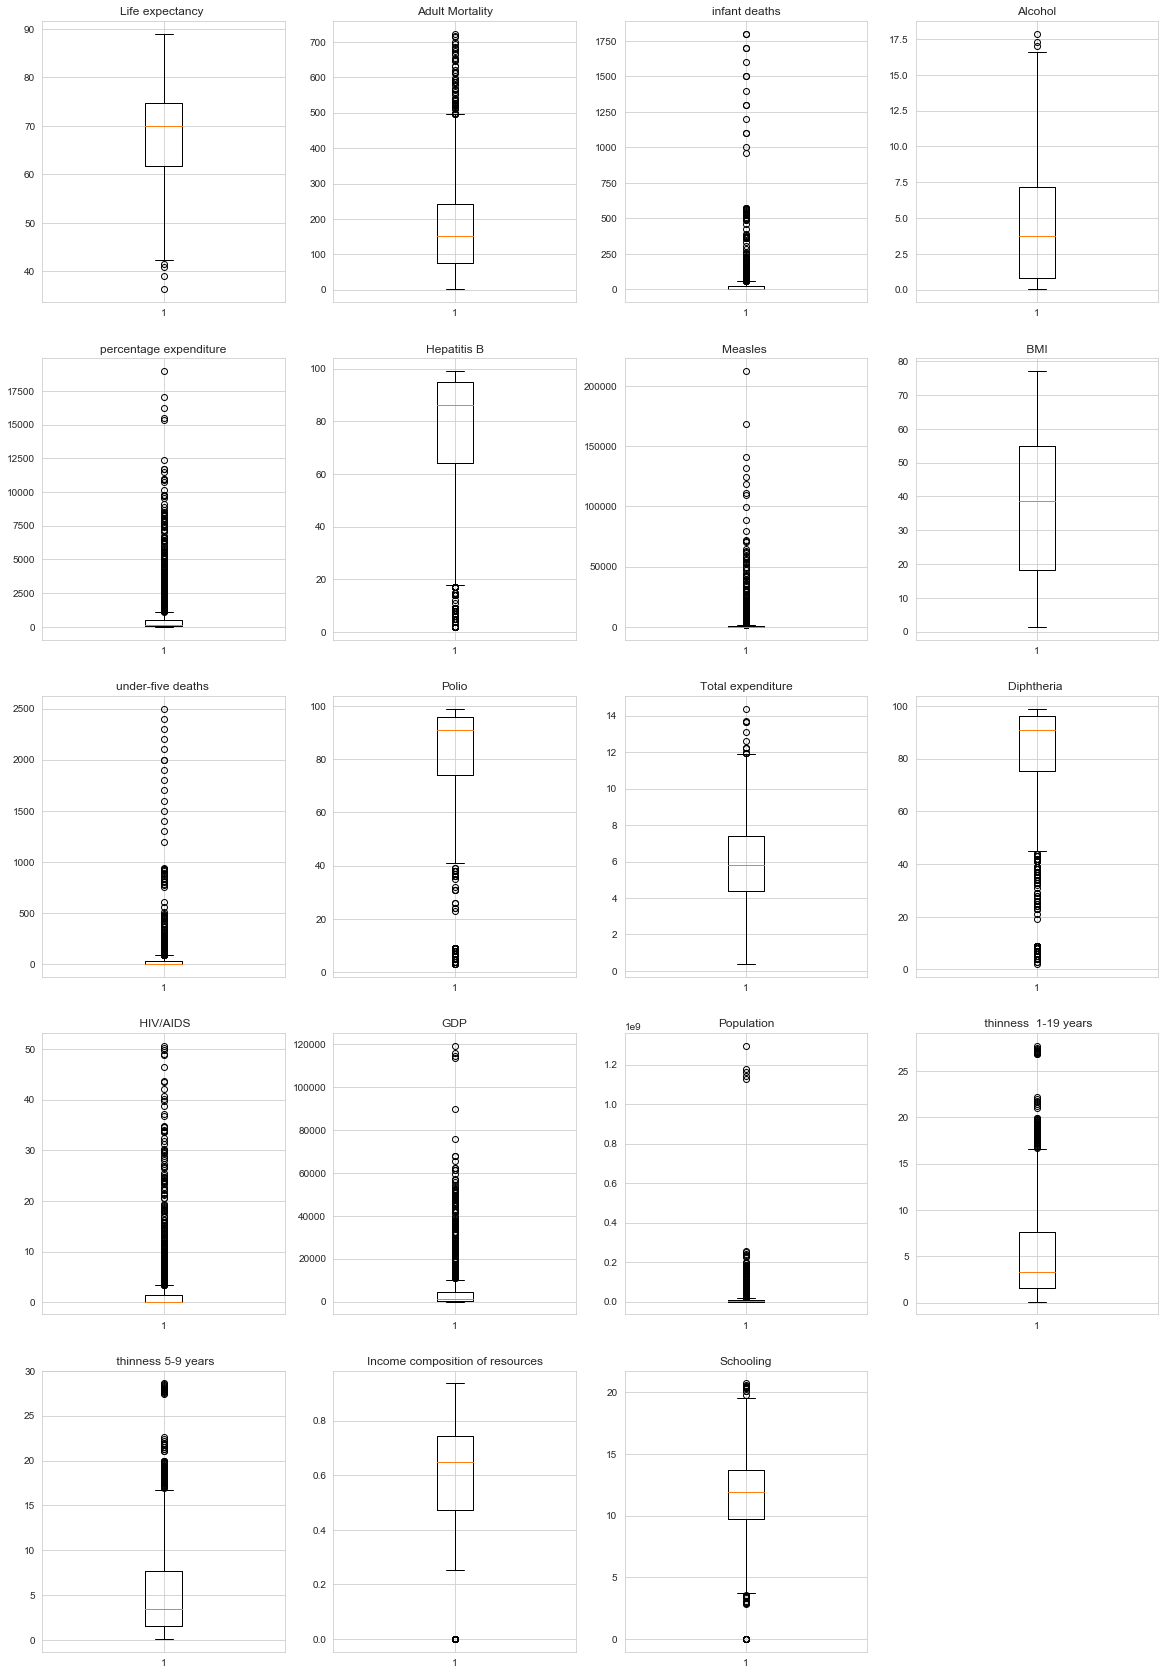

In [15]:
feature_dict = {'Life expectancy ':1, 'Adult Mortality':2,
       'infant deaths':3, 'Alcohol':4, 'percentage expenditure':5, 'Hepatitis B':6,
       'Measles ':7, ' BMI ':8, 'under-five deaths ':9, 'Polio':10, 'Total expenditure':11,
       'Diphtheria ':12, ' HIV/AIDS':13, 'GDP':14, 'Population':15,
       ' thinness  1-19 years':16, ' thinness 5-9 years':17,
       'Income composition of resources':18, 'Schooling':19}

plt.figure(figsize=(20,30))

for feature, feature_index in feature_dict.items():
    plt.subplot(5, 4, feature_index)
    plt.boxplot(lexp_df[feature], whis=1.5)
    plt.title(feature)
    
plt.show()

From our boxplots on each of our chosen features, we see quite a high number of outliers. We can confirm this more rigourously using Tukey's Method:

In [16]:
for feature in feature_dict.keys():
    q_75, q_25 = np.percentile(lexp_df[feature], [75, 25])
    IQR = q_75 - q_25
    minval = q_25 - 1.5*IQR
    maxval = q_75 + 1.5*IQR
    totals = len((np.where((lexp_df[feature] > maxval) | (lexp_df[feature] < minval))[0]))
    print(f'Feature: {feature:<32s} Outliers Total: {totals:<6} Percentage: {totals*100/lexp_df.shape[0]:2.3f}%')

Feature: Life expectancy                  Outliers Total: 4      Percentage: 0.201%
Feature: Adult Mortality                  Outliers Total: 58     Percentage: 2.919%
Feature: infant deaths                    Outliers Total: 198    Percentage: 9.965%
Feature: Alcohol                          Outliers Total: 3      Percentage: 0.151%
Feature: percentage expenditure           Outliers Total: 232    Percentage: 11.676%
Feature: Hepatitis B                      Outliers Total: 216    Percentage: 10.871%
Feature: Measles                          Outliers Total: 361    Percentage: 18.168%
Feature:  BMI                             Outliers Total: 0      Percentage: 0.000%
Feature: under-five deaths                Outliers Total: 227    Percentage: 11.424%
Feature: Polio                            Outliers Total: 159    Percentage: 8.002%
Feature: Total expenditure                Outliers Total: 13     Percentage: 0.654%
Feature: Diphtheria                       Outliers Total: 195    Percent

Some of our features have high percentages of outliers. We will deal with these outliers using winsorization.

In [17]:
from scipy.stats.mstats import winsorize

winsorize_features = ['Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling']

for feature in winsorize_features:
    lexp_df[feature] = winsorize(lexp_df[feature], (0.11, 0.185))

Let's check and see how many outliers there are after our winsorization.

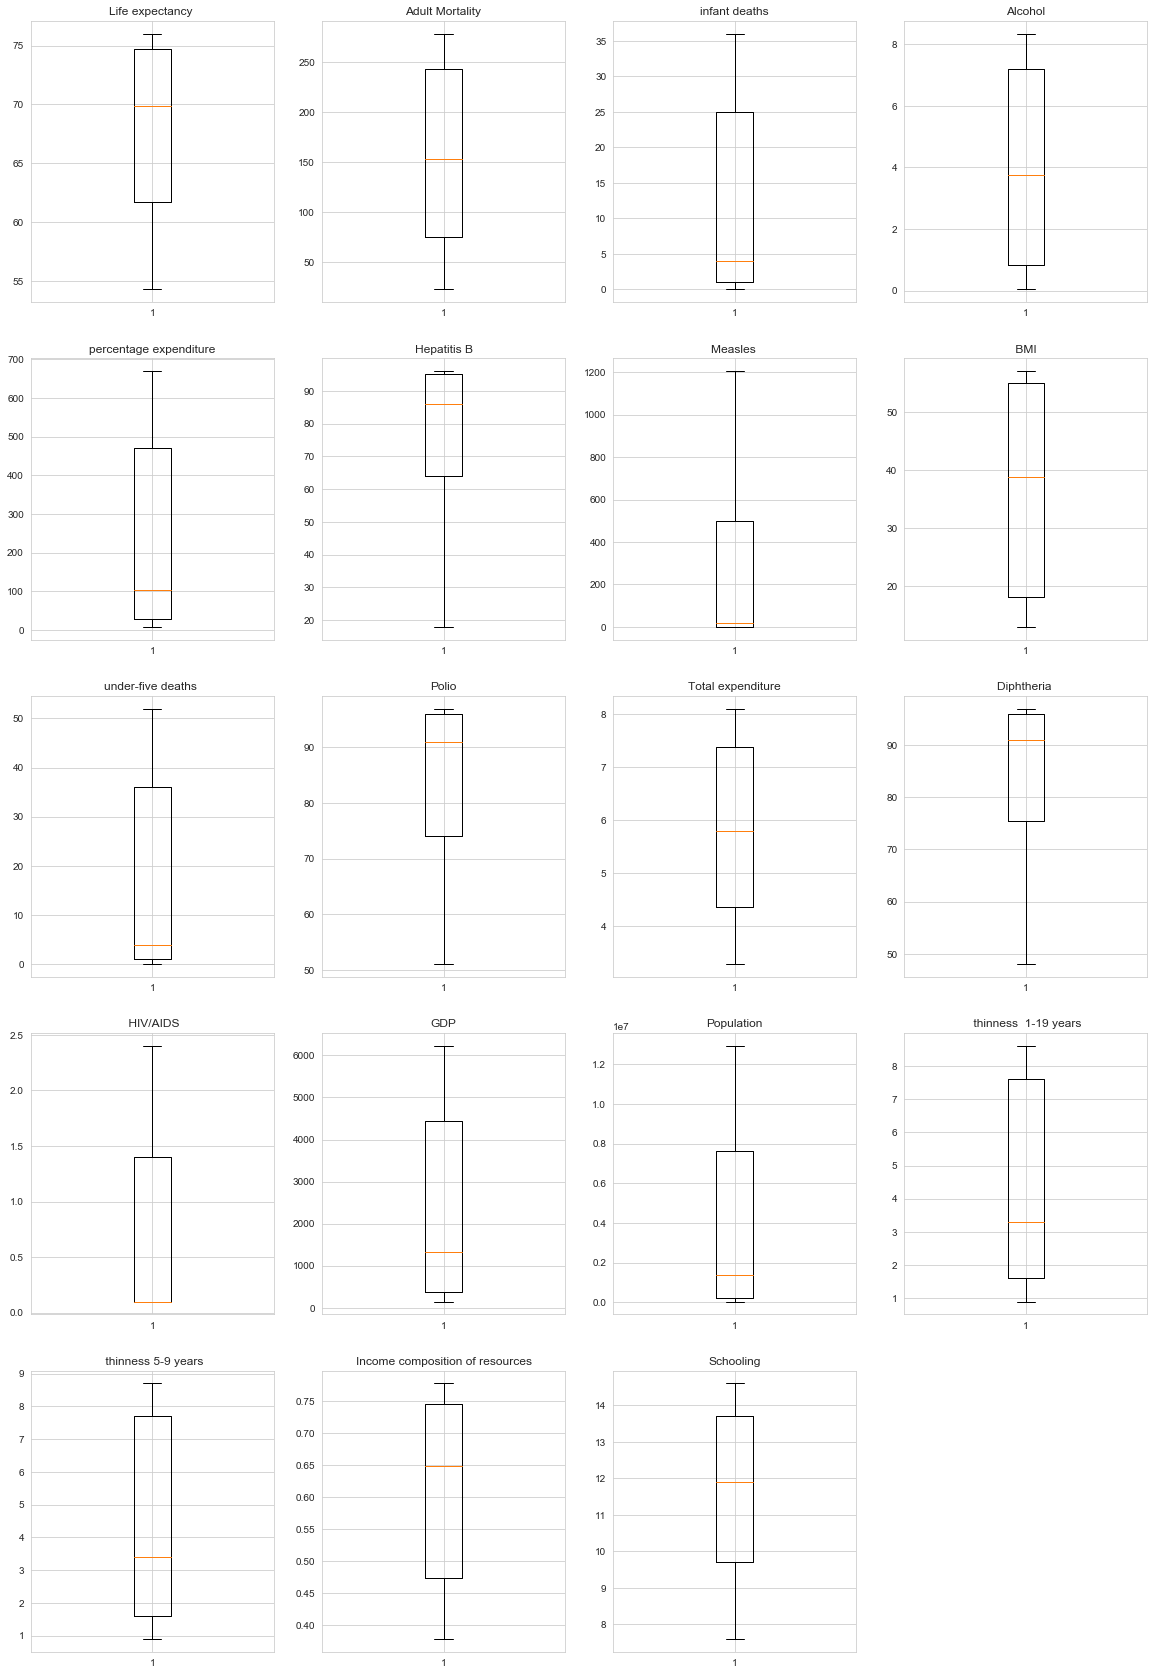

In [18]:
plt.figure(figsize=(20,30))

for feature, feature_index in feature_dict.items():
    plt.subplot(5, 4, feature_index)
    plt.boxplot(lexp_df[feature], whis=1.5)
    plt.title(feature)
    
plt.show()

It looks like from our boxplots that we have succesfully removed our outliers. Let's confirm this with Tukey's method:

In [19]:
for feature in feature_dict.keys():
    q_75, q_25 = np.percentile(lexp_df[feature], [75, 25])
    IQR = q_75 - q_25
    minval = q_25 - 1.5*IQR
    maxval = q_75 + 1.5*IQR
    totals = len((np.where((lexp_df[feature] > maxval) | (lexp_df[feature] < minval))[0]))
    print(f'Feature: {feature:<32s} Outliers Total: {totals:<6} Percentage: {totals*100/lexp_df.shape[0]:2.3f}%')

Feature: Life expectancy                  Outliers Total: 0      Percentage: 0.000%
Feature: Adult Mortality                  Outliers Total: 0      Percentage: 0.000%
Feature: infant deaths                    Outliers Total: 0      Percentage: 0.000%
Feature: Alcohol                          Outliers Total: 0      Percentage: 0.000%
Feature: percentage expenditure           Outliers Total: 0      Percentage: 0.000%
Feature: Hepatitis B                      Outliers Total: 0      Percentage: 0.000%
Feature: Measles                          Outliers Total: 0      Percentage: 0.000%
Feature:  BMI                             Outliers Total: 0      Percentage: 0.000%
Feature: under-five deaths                Outliers Total: 0      Percentage: 0.000%
Feature: Polio                            Outliers Total: 0      Percentage: 0.000%
Feature: Total expenditure                Outliers Total: 0      Percentage: 0.000%
Feature: Diphtheria                       Outliers Total: 0      Percentage:

We have removed all the outliers using winsorization.

# Exploratory Data Analysis (EDA)
Let's now begin with our analysis into our processed dataset.

In [20]:
lexp_df.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,1987,1987.000000,1987,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,...,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000,1987.000000
unique,133,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Albania,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,1702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2006.984902,NaN,67.755460,155.731253,11.950679,3.960798,241.712084,74.627579,314.293407,...,83.399094,5.803724,83.274786,0.736789,2404.425394,4.126168e+06,4.365979,4.424761,0.610946,11.585606
std,NaN,4.323147,NaN,7.718848,89.784795,14.062498,3.127186,255.239661,26.230564,474.588302,...,15.777700,1.677421,16.303114,0.924480,2321.928428,4.957294e+06,2.976533,3.001940,0.143880,2.384275
min,NaN,2000.000000,NaN,54.300000,23.000000,0.000000,0.040000,8.574030,18.000000,0.000000,...,51.000000,3.280000,48.000000,0.100000,146.838510,3.243200e+04,0.900000,0.900000,0.378000,7.600000
25%,NaN,2003.000000,NaN,61.700000,75.000000,1.000000,0.830000,29.469887,64.000000,0.000000,...,74.000000,4.360000,75.500000,0.100000,384.553107,1.967480e+05,1.600000,1.600000,0.473000,9.700000
50%,NaN,2007.000000,NaN,69.900000,153.000000,4.000000,3.770000,104.314473,86.000000,20.000000,...,91.000000,5.800000,91.000000,0.100000,1334.651896,1.396861e+06,3.300000,3.400000,0.648000,11.900000
75%,NaN,2011.000000,NaN,74.700000,243.000000,25.000000,7.190000,470.870122,95.000000,499.500000,...,96.000000,7.385000,96.000000,1.400000,4441.530655,7.625918e+06,7.600000,7.700000,0.745000,13.700000


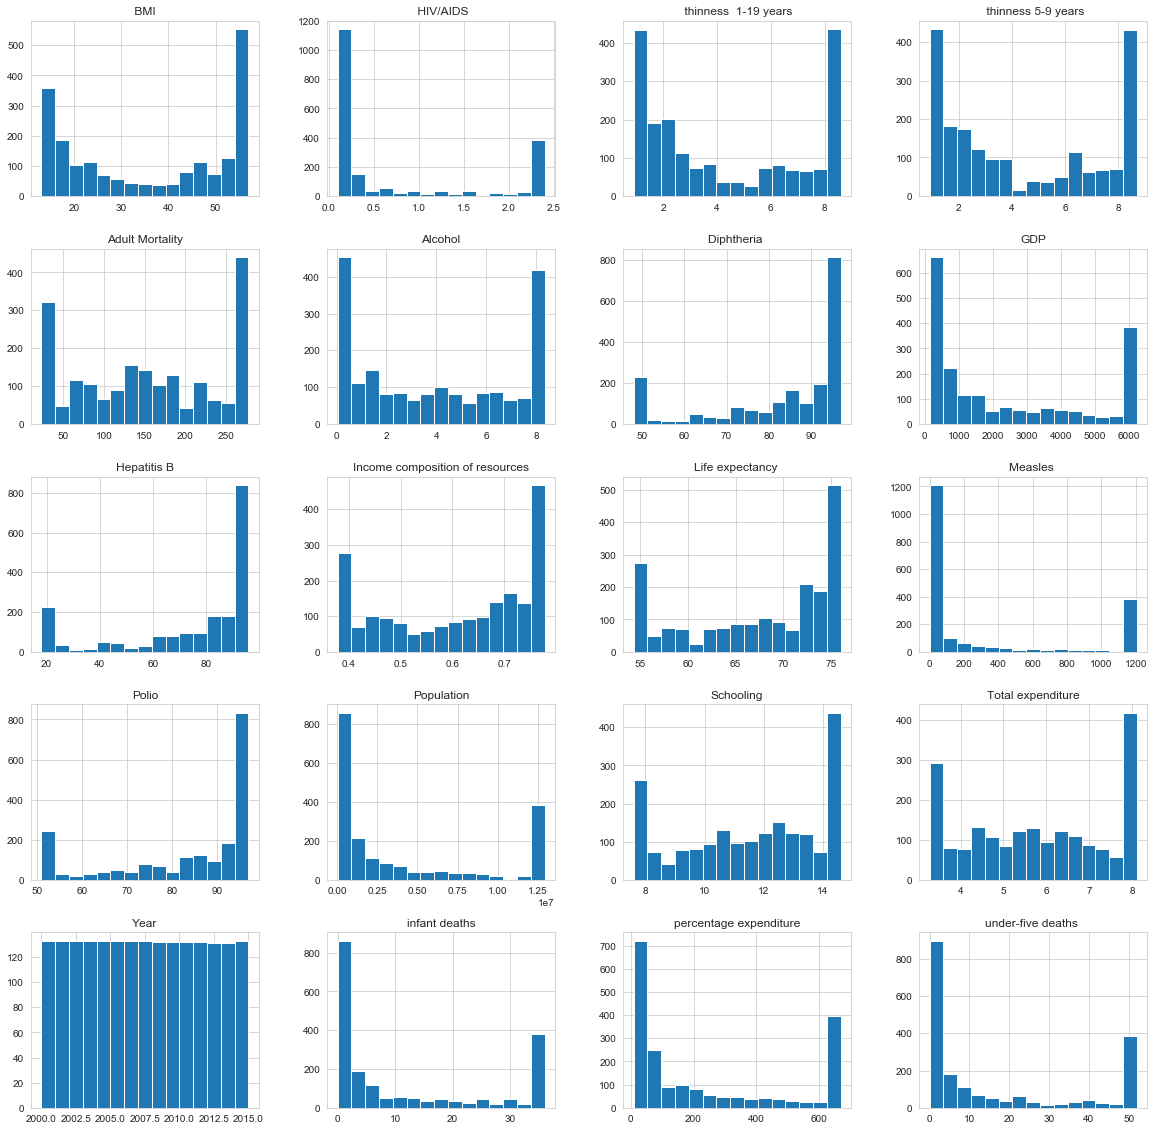

In [21]:
lexp_df.hist(bins=15, figsize=(20,20))
plt.show()

From the histograms above, we can see that there are no particular features that appear normally distributed. Let's take a look at the correlation matrix via a heatmap.

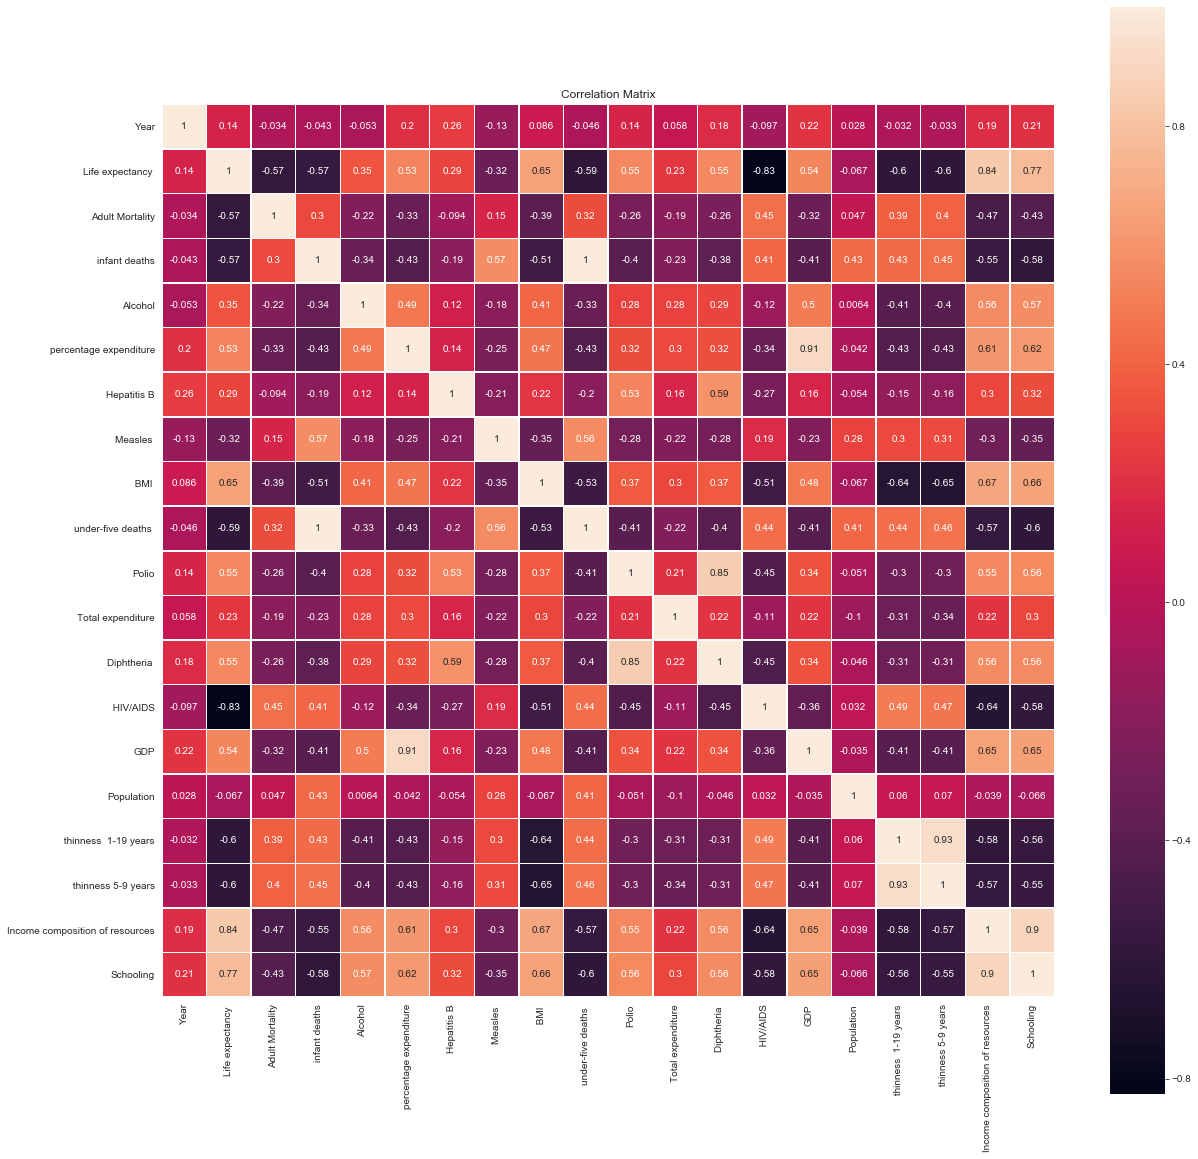

In [22]:
plt.figure(figsize=(20,20))
sns.heatmap(lexp_df.corr(), annot=True, square=True, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

From our correlation matrix, we notice a couple of things. Thinness 1-19 and thineness 5-9 are very similar in their results, so we might consider dropping one of those variables. Income Composition of Resources and Percentage Expenditure seem to be similar. Infant deaths and under-five deaths are also highly correlated and we may consider dropping one of these features as well.

<b> Strongly Positive Correlated Features: </b> BMI, Polio, Diphtheria, GDP, Income Composition of Resources

<b> Strongly Negative Correlated Features: </b> Adult Mortality, Infant Deaths, HIV/AIDS, Thinness 1-19 Years

In [23]:
positive_features = [' BMI ', 'Polio', 'Diphtheria ', 'GDP', 'Income composition of resources']
negative_features = ['Adult Mortality', 'infant deaths', ' HIV/AIDS', ' thinness  1-19 years']

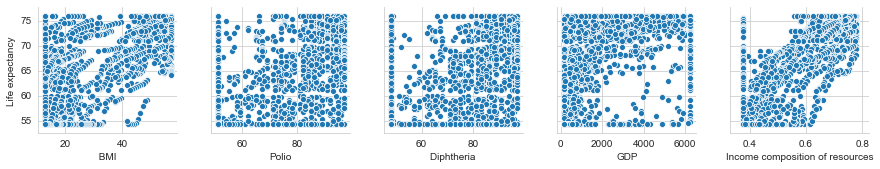

In [24]:
sns.pairplot(data=lexp_df, x_vars = positive_features, y_vars='Life expectancy ')
plt.show()

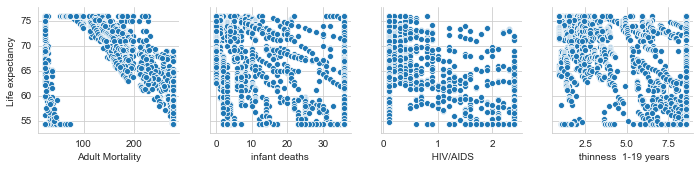

In [25]:
sns.pairplot(data=lexp_df, x_vars = negative_features, y_vars='Life expectancy ')
plt.show()

These scatter plots give us a little idea of where we can see the positive/negative correlations, but let's take a closer look at some variables.

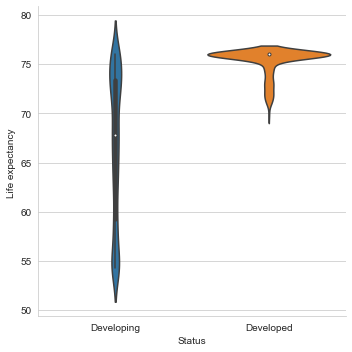

In [26]:
sns.catplot(x='Status', y='Life expectancy ', data=lexp_df, kind='violin')
plt.show()

Whether or not a country is developing or is developed seems to make a big difference on life expectancy, based off a visual inspection of the plot above.

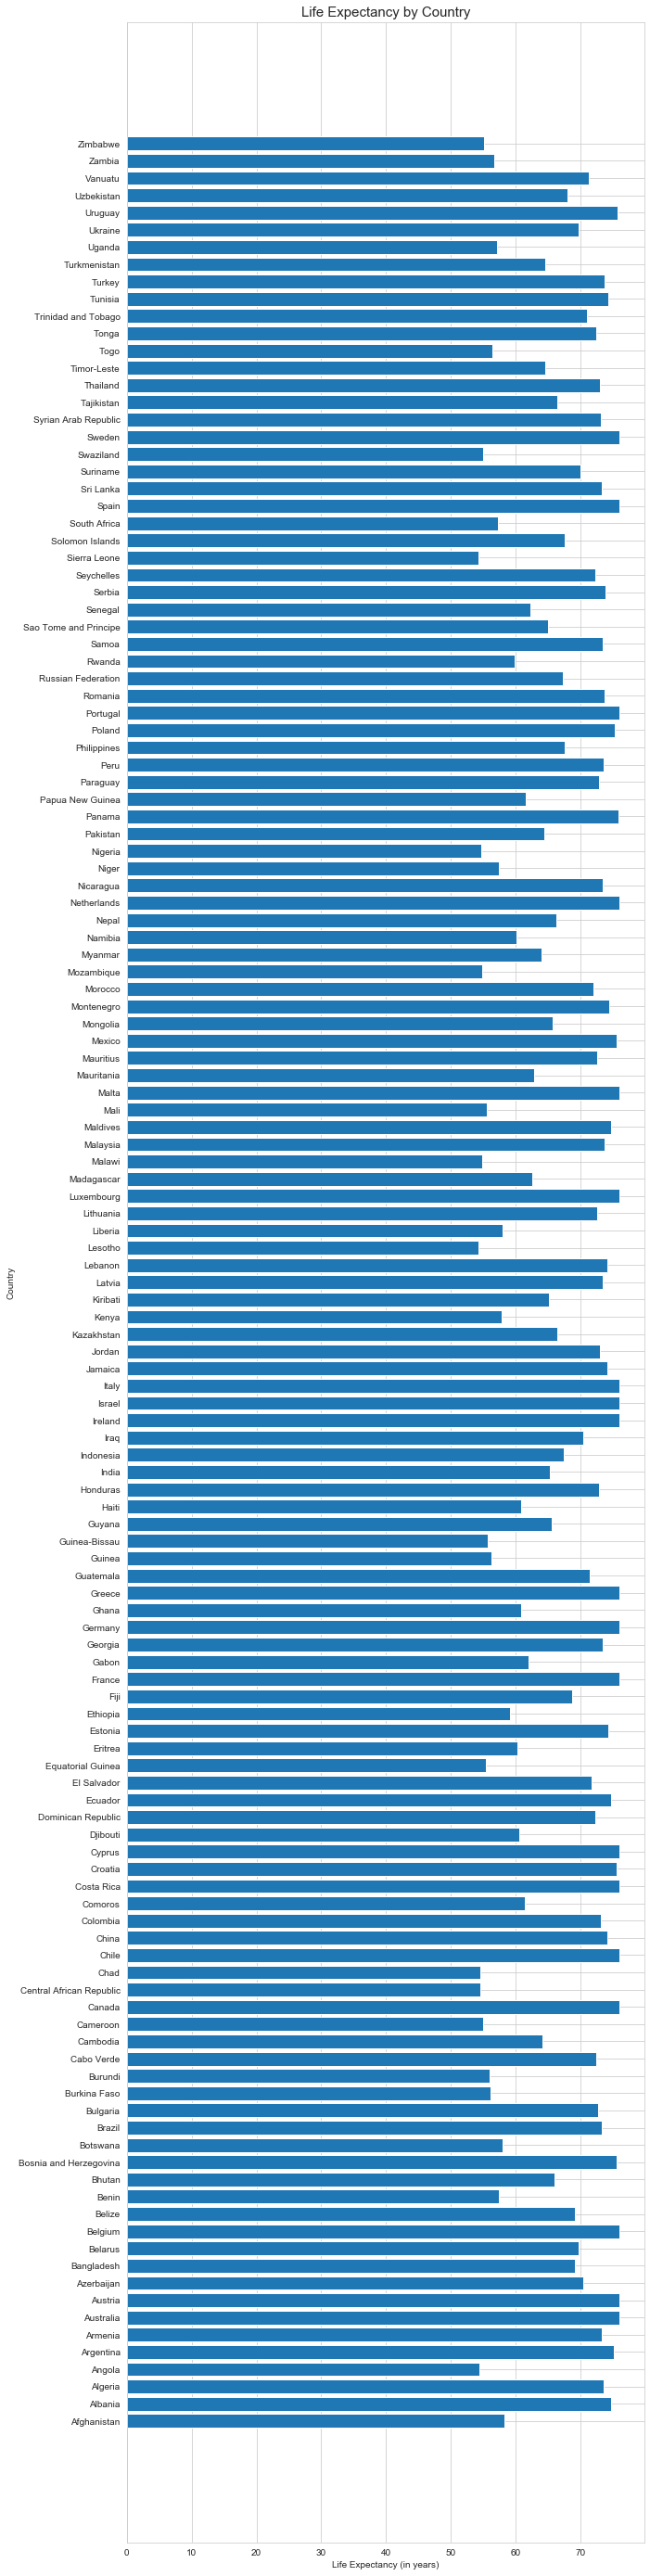

In [27]:
plt.figure(figsize=(10,50))
plt.barh(lexp_df.groupby('Country')['Life expectancy '].count().index,
         lexp_df.groupby('Country')['Life expectancy '].mean())
plt.title('Life Expectancy by Country', fontsize=15)
plt.xlabel('Life Expectancy (in years)')
plt.ylabel('Country')
plt.show()

There are probably way too many countries that would become way too many encoded features. We will instead use country status as an alternative.

## Feature Engineering

Based off our exploratory data analysis, we will include a suite of features that would be ideal for our modeling phase (which we will not perform in this particular module). Let's begin by encoding our status variable:

In [28]:
lexp_df['Status'] = pd.get_dummies(lexp_df['Status'], drop_first=True)

Let's now normalize our selected features from our EDA:

In [30]:
from sklearn.preprocessing import normalize

positive_features = [' BMI ', 'Polio', 'Diphtheria ', 'GDP', 'Income composition of resources']
negative_features = ['Adult Mortality', 'infant deaths', ' HIV/AIDS', ' thinness  1-19 years']
selected_features = positive_features + negative_features + ['Status']

for feature in selected_features:
    lexp_df["norm_"+feature] = normalize(np.array(lexp_df[feature]).reshape(1, -1)).reshape(-1, 1)

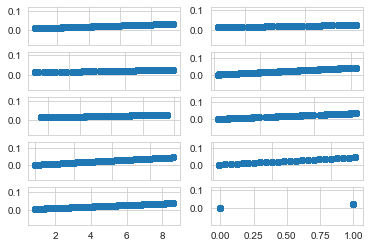

In [32]:
for feature in selected_features:
    plt.subplot(5, 2, selected_features.index(feature)+1)
    plt.scatter(lexp_df[feature], lexp_df["norm_"+feature])

### Principal Component Analysis (PCA)
Using principal component analysis, let's consider our final few features that we normalized to see what to use as our final features for a model:

In [36]:
normalized_features = ['norm_ BMI ', 'norm_Polio', 'norm_Diphtheria ', 
                       'norm_GDP', 'norm_Income composition of resources',
                       'norm_Adult Mortality', 'norm_infant deaths',
                       'norm_ HIV/AIDS', 'norm_ thinness  1-19 years']

X = lexp_df[normalized_features]

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.53118712 0.14501105 0.12305085 0.07872564 0.06661029]


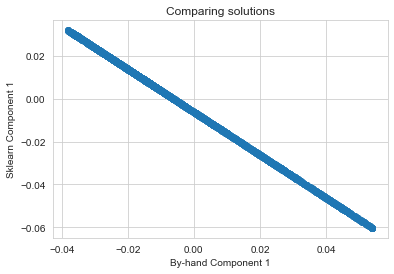

In [37]:
from sklearn.decomposition import PCA
import math

Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(X.T)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

Over 80% of our data can be explained by the first four features.

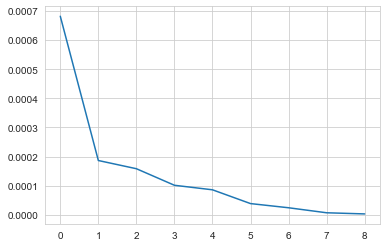

[6.82161403e-04 1.86226160e-04 1.58024422e-04 1.01101084e-04
 8.55422958e-05 3.81485618e-05 2.38077902e-05 6.56615572e-06
 2.64264329e-06]


In [38]:
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

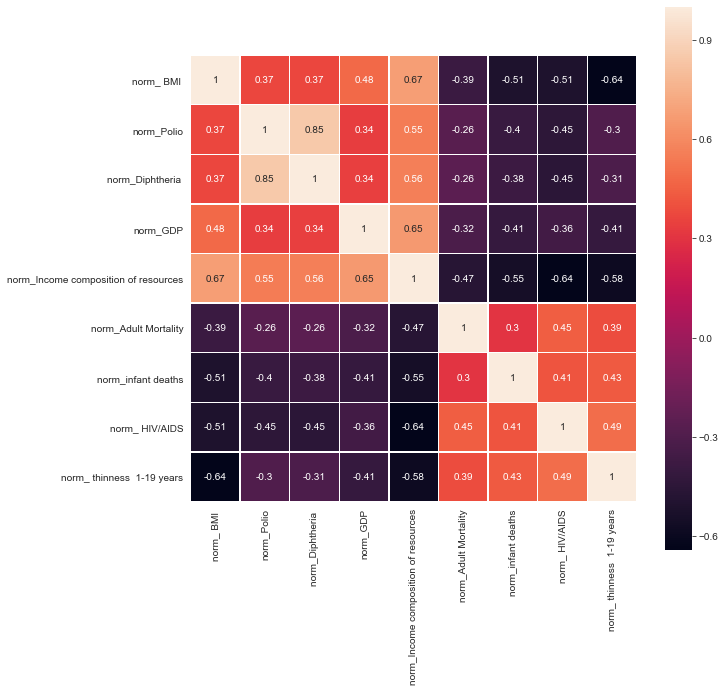

In [39]:
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(), annot=True, square=True, linewidths=0.5)
plt.show()

# Final Summary

Around 80% of the dataset can be explained by just a few continuous features to determine life-expectancy:
* BMI
* Polio 
* Diphtheria 
* GDP

We can see this in the scree plot below, which shows how much of the dataset is explained for each increase in features:

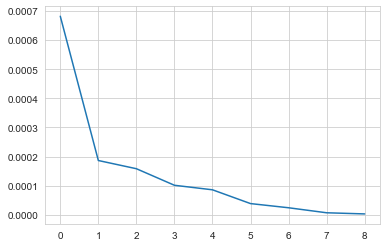

[6.82161403e-04 1.86226160e-04 1.58024422e-04 1.01101084e-04
 8.55422958e-05 3.81485618e-05 2.38077902e-05 6.56615572e-06
 2.64264329e-06]


In [41]:
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

In addition, we would consider adding the categorical feature of country status, whether it is developing or not, as it a strong indicator of life-expectancy as seen in this plot:

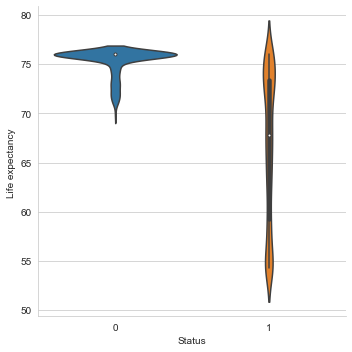

In [40]:
sns.catplot(x='Status', y='Life expectancy ', data=lexp_df, kind='violin')
plt.show()

Where 0 indicates a devleped country vs 1 which is a developing country. We ca see that a wide range of life-expectancies are seen for developing countries, whereas a large saturation of higher age expectancies are seen for devloped countries.

<b>In conclusion</b>, the features to pre